# Setup environment

In [ ]:
import os
import shutil
import tempfile

import matplotlib.pyplot as plt
import numpy as np
import nibabel as nib
from tqdm import tqdm

from monai.losses import DiceCELoss
from monai.inferers import sliding_window_inference
from monai.transforms import (
    AsDiscrete,
    AddChanneld,
    Compose,
    CropForegroundd,
    LoadImaged,
    Orientationd,
    RandFlipd,
    RandCropByPosNegLabeld,
    RandShiftIntensityd,
    ScaleIntensityRanged,
    NormalizeIntensityd,
    Spacingd,
    RandRotate90d,
    ToTensord,
)

from monai.config import print_config
from monai.metrics import DiceMetric
from monai.networks.nets import UNETR, UNet

from monai.data import (
    DataLoader,
    CacheDataset,
    load_decathlon_datalist,
    decollate_batch,
)


import torch

print_config()

# Set up data directory

In [ ]:
directory = os.environ.get("MONAI_DATA_DIRECTORY")
root_dir = tempfile.mkdtemp() if directory is None else directory
size = (96,96,96)
print(root_dir)

# Setup transforms for training and validation

In [ ]:
train_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        AddChanneld(keys=["image", "label"]),
        Spacingd(
            keys=["image", "label"],
            pixdim=(1.0, 1.0, 1.0),
            mode=("bilinear", "nearest"),
        ),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        # ScaleIntensityRanged(
        #     keys=["image"],
        #     a_min=-175,
        #     a_max=250,
        #     b_min=0.0,
        #     b_max=1.0,
        #     clip=True,
        # ),
        NormalizeIntensityd(keys="image", nonzero=True, channel_wise=True),
        CropForegroundd(keys=["image", "label"], source_key="image"),
        RandCropByPosNegLabeld(
            keys=["image", "label"],
            label_key="label",
            spatial_size=size,
            pos=1,
            neg=1,
            num_samples=4,
            image_key="image",
            image_threshold=0,
        ),
        RandFlipd(
            keys=["image", "label"],
            spatial_axis=[0],
            prob=0.10,
        ),
        RandFlipd(
            keys=["image", "label"],
            spatial_axis=[1],
            prob=0.10,
        ),
        RandFlipd(
            keys=["image", "label"],
            spatial_axis=[2],
            prob=0.10,
        ),
        RandRotate90d(
            keys=["image", "label"],
            prob=0.10,
            max_k=3,
        ),
        RandShiftIntensityd(
            keys=["image"],
            offsets=0.10,
            prob=0.50,
        ),
        ToTensord(keys=["image", "label"]),
    ]
)
val_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        AddChanneld(keys=["image", "label"]),
        Spacingd(
            keys=["image", "label"],
            pixdim=(1.0, 1.0, 1.0),
            mode=("bilinear", "nearest"),
        ),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        # ScaleIntensityRanged(
        #     keys=["image"], a_min=-175, a_max=250, b_min=0.0, b_max=1.0, clip=True
        # ),
        NormalizeIntensityd(keys="image", nonzero=True, channel_wise=True),
        CropForegroundd(keys=["image", "label"], source_key="image"),
        ToTensord(keys=["image", "label"]),
    ]
)

# Download dataset and format in the folder

In [ ]:
import nibabel as nib

def liver_bounding_box(liver):

    X, Y, Z = np.where(liver > 0)
    return np.min(X), np.max(X), np.min(Y), np.max(Y), np.min(Z), np.max(Z)

def get_average_liver_size(dataset_path):

    shapes = np.zeros((35,6))
    idx = 0

    for name in sorted(os.listdir(os.path.join(os.path.abspath(os.getcwd()), 'VEELA/dataset'))):
        if '-VE-liv.nii.gz' in name:
            liver_nifti = nib.load(os.path.join(os.path.abspath(os.getcwd()), 'VEELA/dataset/' + name))
            liver = liver_nifti.get_fdata()
            shapes[idx,0], shapes[idx,1], shapes[idx,2], shapes[idx,3], shapes[idx,4], shapes[idx,5] = liver_bounding_box(liver)
            idx +=1
    
    shapes_average = np.mean(shapes, axis = 0).astype(int)
    print('Average liver coordinates:\n\tx_min: {}\tx_max: {}\n\ty_min: {}\ty_max: {}\n\tz_min: {}\tz_max: {}\nAverage size: {}x{}x{}'.format(
           int(shapes_average[0]), int(shapes_average[1]), int(shapes_average[2]), int(shapes_average[3]), int(shapes_average[4]), int(shapes_average[5]),
           int(abs(shapes_average[0] - shapes_average[1]) + 1), 
           int(abs(shapes_average[2] - shapes_average[3]) + 1), 
           int(abs(shapes_average[4] - shapes_average[5]) + 1), 
    ))
    return [int(abs(shapes_average[0] - shapes_average[1]) + 1), int(abs(shapes_average[2] - shapes_average[3]) + 1), int(abs(shapes_average[4] - shapes_average[5]) + 1)], shapes.astype(int)

In [ ]:
average_size,liver_coord = get_average_liver_size(os.path.join(os.path.abspath(os.getcwd()), 'VEELA/dataset'))

In [ ]:
info_dict = {}

In [ ]:
def append_value_to_dict(dict_obj, key, value):

    # Check if key exist in dict or not
    if key in dict_obj:
        # Key exist in dict.
        # Check if type of value of key is list or not
        if not isinstance(dict_obj[key], list):
            # If type is not list then make it list
            dict_obj[key] = [dict_obj[key]]
        # Append the value in list
        dict_obj[key].append(value)
    else:
        # As key is not in dict,
        # so, add key-value pair
        dict_obj[key] = value

def get_liver_bounding_box(liver):

    X, Y, Z = np.where(liver > 0)
    return np.array([np.min(X), np.max(X), np.min(Y), np.max(Y), np.min(Z), np.max(Z)])

def process_dataset(dataset_path, info_dict):

    for name in sorted(os.listdir(dataset_path)):
        if '-VE-liv.nii.gz' in name: # LIVER MASKS
            liver_nifti = nib.load(dataset_path + '/'+name)
            liver_coords = get_liver_bounding_box(liver_nifti.get_fdata())
            append_value_to_dict(info_dict, 'Liver coordinates', liver_coords)
            append_value_to_dict(info_dict, 'Affine matrix', liver_nifti.affine)
        
        elif '-VE.nii.gz' in name: # INPUT VOLUME
            append_value_to_dict(info_dict, 'Image name', name)
            append_value_to_dict(info_dict, 'Volume shape', nib.load(dataset_path + '/'+ name).shape)
            append_value_to_dict(info_dict, 'Header', nib.load(dataset_path + '/'+ name).header)
            append_value_to_dict(info_dict, 'Image nifti object', nib.load(dataset_path + '/'+ name))
        
        elif '-VE-por.nii.gz' in name: # PORTAL VEINS
            append_value_to_dict(info_dict, 'Portal veins name', name)
            append_value_to_dict(info_dict, 'Portal nifti object', nib.load(dataset_path + '/'+ name))
        elif '-VE-hep.nii.gz' in name: # HEPATIC VEINS
            append_value_to_dict(info_dict, 'Hepatic veins name', name)
            append_value_to_dict(info_dict, 'Hepatic nifti object', nib.load(dataset_path + '/'+ name))

    return info_dict

    

In [ ]:
info_dict = process_dataset(os.path.join(os.path.abspath(os.getcwd()), 'VEELA/dataset'), info_dict)

In [ ]:
!rm -r /home/guijosa/Documents/PythonDocs/UNETR/data/

In [ ]:
import skimage.transform as skTrans

def create_directory():
    os.makedirs("./data/imagesTr")
    os.makedirs("./data/labelsTr")
    os.makedirs("./data/imagesTs")
    os.makedirs("./data/labelsTs")
    os.makedirs("./data/results")

def split_dataset(info_dict, dataset_path):

    for idx, name in enumerate(info_dict['Image name']):
        ima = nib.load(os.path.join(dataset_path, name)).get_fdata()
        # 3D indexing volume_images
        liver = ima[
            info_dict['Liver coordinates'][idx][0]:info_dict['Liver coordinates'][idx][1] + 1,
            info_dict['Liver coordinates'][idx][2]:info_dict['Liver coordinates'][idx][3] + 1,
            info_dict['Liver coordinates'][idx][4]:info_dict['Liver coordinates'][idx][5] + 1
        ]
        # resized_liver = skTrans.resize(liver, (average_size[0], average_size[1], average_size[2]), order = 1, preserve_range=True)
        resized_liver = skTrans.resize(liver, size, order = 1, preserve_range=True)
        output_ima = nib.Nifti1Image(resized_liver, info_dict['Affine matrix'][idx], info_dict['Header'][idx])
        if len(os.listdir('./data/imagesTr')) < 28:
            nib.save(output_ima, './data/imagesTr/' + info_dict['Image name'][idx].split('.')[0] + '-liver.nii.gz')
        else:
            nib.save(output_ima, './data/imagesTs/' + info_dict['Image name'][idx].split('.')[0] + '-liver.nii.gz')

    for idx, name in enumerate(info_dict['Portal veins name']):
        ima = nib.load(os.path.join(dataset_path, name)).get_fdata().astype(np.uint8)
        # 3D indexing
        liver = ima[
            info_dict['Liver coordinates'][idx][0]:info_dict['Liver coordinates'][idx][1] + 1,
            info_dict['Liver coordinates'][idx][2]:info_dict['Liver coordinates'][idx][3] + 1,
            info_dict['Liver coordinates'][idx][4]:info_dict['Liver coordinates'][idx][5] + 1
        ]
        # resized_liver = skTrans.resize(liver, (average_size[0], average_size[1], average_size[2]), order = 1, preserve_range=True)
        resized_liver = skTrans.resize(liver, size, preserve_range=True)

        resized_liver[np.where(resized_liver > 0.95)] = 1
        resized_liver[np.where(resized_liver != 1)] = 0

        output_ima = nib.Nifti1Image(resized_liver, info_dict['Affine matrix'][idx], info_dict['Header'][idx])
        if len(os.listdir('./data/labelsTr')) < 28:
            nib.save(output_ima, './data/labelsTr/' + info_dict['Image name'][idx].split('.')[0] + '-liver_por_GT.nii.gz')
        else:
            nib.save(output_ima, './data/labelsTs/'+ info_dict['Image name'][idx].split('.')[0] + '-liver_por_GT.nii.gz')


dataset_path = os.path.join(os.path.abspath(os.getcwd()), 'VEELA/dataset')
try:
    create_directory()
    split_dataset(info_dict, dataset_path)
    
except FileExistsError:
    # split_dataset(info_dict, dataset_path)
    pass
        


In [ ]:
# K-FOLD CROSS VALIDATION

# Numer of folds
k = 4
# Split dataset for Training, Validation and Test
split =[23, 5, 7]
for fold in range(k):
    create_directory()
    


In [ ]:
import random
random.choice([1,8,3,5,9,1,6,3,9,5,1,4])

In [ ]:
import json
# EJECUTAR ESTEEEEEEEE

# Data to be written
dictionary = {
    "labels": {
        "0": "background",
        "1": "portal_vessels"
    },
    "modality": {
        "0": "CT"
    },
    "numTest": 20,
    "numTraining": 80,
    "test": [
        "imagesTs/033-VE-liver.nii.gz",
        "imagesTs/034-VE-liver.nii.gz",
        "imagesTs/035-VE-liver.nii.gz",
        "imagesTs/036-VE-liver.nii.gz",
        "imagesTs/037-VE-liver.nii.gz",
        "imagesTs/039-VE-liver.nii.gz",
        "imagesTs/040-VE-liver.nii.gz"
    ],
    "training": [
    {
        "image": "imagesTr/001-VE-liver.nii.gz",
        "label": "labelsTr/001-VE-liver_por_GT.nii.gz"
    },
    {
        "image": "imagesTr/002-VE-liver.nii.gz",
        "label": "labelsTr/002-VE-liver_por_GT.nii.gz"
    },
    {
        "image": "imagesTr/003-VE-liver.nii.gz",
        "label": "labelsTr/003-VE-liver_por_GT.nii.gz"
    },
    {
        "image": "imagesTr/004-VE-liver.nii.gz",
        "label": "labelsTr/004-VE-liver_por_GT.nii.gz"
    },
    {
        "image": "imagesTr/005-VE-liver.nii.gz",
        "label": "labelsTr/005-VE-liver_por_GT.nii.gz"
    },
    {
        "image": "imagesTr/006-VE-liver.nii.gz",
        "label": "labelsTr/006-VE-liver_por_GT.nii.gz"
    },
    {
        "image": "imagesTr/007-VE-liver.nii.gz",
        "label": "labelsTr/007-VE-liver_por_GT.nii.gz"
    },
    {
        "image": "imagesTr/008-VE-liver.nii.gz",
        "label": "labelsTr/008-VE-liver_por_GT.nii.gz"
    },
    {
        "image": "imagesTr/009-VE-liver.nii.gz",
        "label": "labelsTr/009-VE-liver_por_GT.nii.gz"
    },
    {
        "image": "imagesTr/010-VE-liver.nii.gz",
        "label": "labelsTr/010-VE-liver_por_GT.nii.gz"
    },
    {
        "image": "imagesTr/011-VE-liver.nii.gz",
        "label": "labelsTr/011-VE-liver_por_GT.nii.gz"
    },
    {
        "image": "imagesTr/012-VE-liver.nii.gz",
        "label": "labelsTr/012-VE-liver_por_GT.nii.gz"
    },
    {
        "image": "imagesTr/013-VE-liver.nii.gz",
        "label": "labelsTr/013-VE-liver_por_GT.nii.gz"
    },
    {
        "image": "imagesTr/014-VE-liver.nii.gz",
        "label": "labelsTr/014-VE-liver_por_GT.nii.gz"
    },
    {
        "image": "imagesTr/015-VE-liver.nii.gz",
        "label": "labelsTr/015-VE-liver_por_GT.nii.gz"
    },
    {
        "image": "imagesTr/016-VE-liver.nii.gz",
        "label": "labelsTr/016-VE-liver_por_GT.nii.gz"
    },
    {
        "image": "imagesTr/017-VE-liver.nii.gz",
        "label": "labelsTr/017-VE-liver_por_GT.nii.gz"
    },
    {
        "image": "imagesTr/018-VE-liver.nii.gz",
        "label": "labelsTr/018-VE-liver_por_GT.nii.gz"
    },
    {
        "image": "imagesTr/019-VE-liver.nii.gz",
        "label": "labelsTr/019-VE-liver_por_GT.nii.gz"
    },
    {
        "image": "imagesTr/020-VE-liver.nii.gz",
        "label": "labelsTr/020-VE-liver_por_GT.nii.gz"
    },
    {
        "image": "imagesTr/022-VE-liver.nii.gz",
        "label": "labelsTr/022-VE-liver_por_GT.nii.gz"
    },
    {
        "image": "imagesTr/023-VE-liver.nii.gz",
        "label": "labelsTr/023-VE-liver_por_GT.nii.gz"
    },
    {
        "image": "imagesTr/025-VE-liver.nii.gz",
        "label": "labelsTr/025-VE-liver_por_GT.nii.gz"
    },
],
    "validation": [
    {
        "image": "imagesTr/027-VE-liver.nii.gz",
        "label": "labelsTr/027-VE-liver_por_GT.nii.gz"
    },
    {
        "image": "imagesTr/028-VE-liver.nii.gz",
        "label": "labelsTr/028-VE-liver_por_GT.nii.gz"
    },
    {
        "image": "imagesTr/030-VE-liver.nii.gz",
        "label": "labelsTr/030-VE-liver_por_GT.nii.gz"
    },
    {
        "image": "imagesTr/031-VE-liver.nii.gz",
        "label": "labelsTr/031-VE-liver_por_GT.nii.gz"
    },
    {
        "image": "imagesTr/032-VE-liver.nii.gz",
        "label": "labelsTr/032-VE-liver_por_GT.nii.gz"
    },
]
}

# Serializing json 
json_object = json.dumps(dictionary, indent = 4)
  
# Writing to sample.json
with open("./data/VEELA.json", "w") as outfile:
    outfile.write(json_object)

In [ ]:
import json

# Data to be written
dictionary = {
   "description": "btcv yucheng",
    "labels": {
        "0": "background",
        "1": "portal_vessels"
    },
    "licence": "yt",
    "modality": {
        "0": "CT"
    },
    "name": "btcv",
    "numTest": 20,
    "numTraining": 80,
    "reference": "Vanderbilt University",
    "release": "1.0 02/02/2022",
    "tensorImageSize": "3D",
    "test": [
        "imagesTs/033-VE-liver.nii.gz",
        "imagesTs/034-VE-liver.nii.gz",
        "imagesTs/035-VE-liver.nii.gz",
        "imagesTs/036-VE-liver.nii.gz",
        "imagesTs/037-VE-liver.nii.gz",
        "imagesTs/039-VE-liver.nii.gz",
        "imagesTs/040-VE-liver.nii.gz"
    ],
    "training": [
    {
        "image": "imagesTr/001-VE-liver.nii.gz",
        "label": "labelsTr/001-VE-liver_por_GT.nii.gz"
    },
    {
        "image": "imagesTr/002-VE-liver.nii.gz",
        "label": "labelsTr/002-VE-liver_por_GT.nii.gz"
    },
    {
        "image": "imagesTr/003-VE-liver.nii.gz",
        "label": "labelsTr/003-VE-liver_por_GT.nii.gz"
    },
    {
        "image": "imagesTr/004-VE-liver.nii.gz",
        "label": "labelsTr/004-VE-liver_por_GT.nii.gz"
    },
    {
        "image": "imagesTr/005-VE-liver.nii.gz",
        "label": "labelsTr/005-VE-liver_por_GT.nii.gz"
    },
    {
        "image": "imagesTr/006-VE-liver.nii.gz",
        "label": "labelsTr/006-VE-liver_por_GT.nii.gz"
    },
    {
        "image": "imagesTr/007-VE-liver.nii.gz",
        "label": "labelsTr/007-VE-liver_por_GT.nii.gz"
    },
    {
        "image": "imagesTr/008-VE-liver.nii.gz",
        "label": "labelsTr/008-VE-liver_por_GT.nii.gz"
    },
    {
        "image": "imagesTr/009-VE-liver.nii.gz",
        "label": "labelsTr/009-VE-liver_por_GT.nii.gz"
    },
    {
        "image": "imagesTr/010-VE-liver.nii.gz",
        "label": "labelsTr/010-VE-liver_por_GT.nii.gz"
    },
    {
        "image": "imagesTr/011-VE-liver.nii.gz",
        "label": "labelsTr/011-VE-liver_por_GT.nii.gz"
    },
    {
        "image": "imagesTr/012-VE-liver.nii.gz",
        "label": "labelsTr/012-VE-liver_por_GT.nii.gz"
    },
    {
        "image": "imagesTr/013-VE-liver.nii.gz",
        "label": "labelsTr/013-VE-liver_por_GT.nii.gz"
    },
    {
        "image": "imagesTr/014-VE-liver.nii.gz",
        "label": "labelsTr/014-VE-liver_por_GT.nii.gz"
    },
    {
        "image": "imagesTr/015-VE-liver.nii.gz",
        "label": "labelsTr/015-VE-liver_por_GT.nii.gz"
    },
    {
        "image": "imagesTr/016-VE-liver.nii.gz",
        "label": "labelsTr/016-VE-liver_por_GT.nii.gz"
    },
    {
        "image": "imagesTr/017-VE-liver.nii.gz",
        "label": "labelsTr/017-VE-liver_por_GT.nii.gz"
    },
    {
        "image": "imagesTr/018-VE-liver.nii.gz",
        "label": "labelsTr/018-VE-liver_por_GT.nii.gz"
    },
    {
        "image": "imagesTr/019-VE-liver.nii.gz",
        "label": "labelsTr/019-VE-liver_por_GT.nii.gz"
    },
    {
        "image": "imagesTr/020-VE-liver.nii.gz",
        "label": "labelsTr/020-VE-liver_por_GT.nii.gz"
    },
    {
        "image": "imagesTr/022-VE-liver.nii.gz",
        "label": "labelsTr/022-VE-liver_por_GT.nii.gz"
    },
    {
        "image": "imagesTr/023-VE-liver.nii.gz",
        "label": "labelsTr/023-VE-liver_por_GT.nii.gz"
    },
    {
        "image": "imagesTr/025-VE-liver.nii.gz",
        "label": "labelsTr/025-VE-liver_por_GT.nii.gz"
    },
],
"validation": [
    {
        "image": "imagesTr/027-VE-liver.nii.gz",
        "label": "labelsTr/027-VE-liver_por_GT.nii.gz"
    },
    {
        "image": "imagesTr/028-VE-liver.nii.gz",
        "label": "labelsTr/028-VE-liver_por_GT.nii.gz"
    },
    {
        "image": "imagesTr/030-VE-liver.nii.gz",
        "label": "labelsTr/030-VE-liver_por_GT.nii.gz"
    },
    {
        "image": "imagesTr/031-VE-liver.nii.gz",
        "label": "labelsTr/031-VE-liver_por_GT.nii.gz"
    },
    {
        "image": "imagesTr/032-VE-liver.nii.gz",
        "label": "labelsTr/032-VE-liver_por_GT.nii.gz"
    },
]
}

# Serializing json 
json_object = json.dumps(dictionary, indent = 4)
  
# Writing to sample.json
with open("./data/VEELA.json", "w") as outfile:
    outfile.write(json_object)

# Load dataset

In [21]:
datasets = './data/VEELA.json'
datalist = load_decathlon_datalist(datasets, True, "training")
val_files = load_decathlon_datalist(datasets, True, "validation")
train_ds = CacheDataset(
    data=datalist,
    transform=train_transforms,
    cache_num=23,
    cache_rate=1.0,
    num_workers=8,
)
train_loader = DataLoader(
    train_ds, batch_size=8, shuffle=True, num_workers=8, pin_memory=True
)
val_ds = CacheDataset(
    data=val_files, transform=val_transforms, cache_num=5, cache_rate=1.0, num_workers=4
)
val_loader = DataLoader(
    val_ds, batch_size=8, shuffle=False, num_workers=4, pin_memory=True
)

Loading dataset: 100%|██████████| 5/5 [00:00<00:00, 23.01it/s]


# Create Model, Loss, Optimizer

In [22]:
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = UNet(
    spatial_dims=3,
    in_channels=1,
    out_channels=1,
    channels=(16,32,64,128,256),
    strides = (2,2,2,2)

).to(device)

loss_function = DiceCELoss(sigmoid=True)
torch.backends.cudnn.benchmark = True
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-5)

In [ ]:
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = UNETR(
    in_channels=1,
    out_channels=1,
    img_size=size,
    feature_size=16,
    hidden_size=768, # 1920  768
    mlp_dim=3072, # 7680   3072
    num_heads=16,
    pos_embed="perceptron",
    norm_name="instance",
    res_block=True,
    dropout_rate=0.0,
).to(device)

loss_function = DiceCELoss(sigmoid=True)
torch.backends.cudnn.benchmark = True
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-5)

In [ ]:
from torchsummary import summary
summary(model, (1,96,96,96))

In [19]:
import torch
torch.cuda.empty_cache()

# Execute a typical Pytorch training process

In [23]:
def validation(epoch_iterator_val):
    model.eval()
    dice_vals = list()
    with torch.no_grad():
        for step, batch in enumerate(epoch_iterator_val):
            val_inputs, val_labels = (batch["image"].cuda(), batch["label"].cuda())
            val_outputs = sliding_window_inference(val_inputs, size, 4, model)
            val_labels_list = decollate_batch(val_labels)
            val_labels_convert = [
                post_label(val_label_tensor) for val_label_tensor in val_labels_list
            ]
            val_outputs_list = decollate_batch(val_outputs)
            val_output_convert = [
                post_pred(val_pred_tensor) for val_pred_tensor in val_outputs_list
            ]
            dice_metric(y_pred=val_output_convert, y=val_labels_convert)
            dice = dice_metric.aggregate().item()
            dice_vals.append(dice)
            epoch_iterator_val.set_description(
                "Validate (%d / %d Steps) (dice=%2.5f)" % (global_step, 10.0, dice)
            )
        dice_metric.reset()
    mean_dice_val = np.mean(dice_vals)
    return mean_dice_val


def train(global_step, train_loader, dice_val_best, global_step_best):
    model.train()
    epoch_loss = 0
    step = 0
    epoch_iterator = tqdm(
        train_loader, desc="Training (X / X Steps) (loss=X.X)", dynamic_ncols=True
    )
    for step, batch in enumerate(epoch_iterator):
        step += 1
        x, y = (batch["image"].cuda(), batch["label"].cuda())
        logit_map = model(x)
        loss = loss_function(logit_map, y)
        loss.backward()
        epoch_loss += loss.item()
        optimizer.step()
        optimizer.zero_grad()
        epoch_iterator.set_description(
            "Training (%d / %d Steps) (loss=%2.5f)" % (global_step, max_iterations, loss)
        )
        if (
            global_step % eval_num == 0 and global_step != 0
        ) or global_step == max_iterations:
            epoch_iterator_val = tqdm(
                val_loader, desc="Validate (X / X Steps) (dice=X.X)", dynamic_ncols=True
            )
            dice_val = validation(epoch_iterator_val)
            epoch_loss /= step
            epoch_loss_values.append(epoch_loss)
            metric_values.append(dice_val)
            if dice_val > dice_val_best:
                dice_val_best = dice_val
                global_step_best = global_step
                torch.save(
                    model.state_dict(), os.path.join(root_dir, "best_metric_model.pth")
                )
                print(
                    "Model Was Saved ! Current Best Avg. Dice: {} Current Avg. Dice: {}".format(
                        dice_val_best, dice_val
                    )
                )
            else:
                print(
                    "Model Was Not Saved ! Current Best Avg. Dice: {} Current Avg. Dice: {}".format(
                        dice_val_best, dice_val
                    )
                )
        global_step += 1
    return global_step, dice_val_best, global_step_best


max_iterations = 25000
eval_num = 500
post_label = AsDiscrete(to_onehot = 2)
post_pred = AsDiscrete(argmax=True, to_onehot = 2)
dice_metric = DiceMetric(include_background=True, reduction="mean", get_not_nans=False)
global_step = 0
dice_val_best = 0.0
global_step_best = 0
epoch_loss_values = []
metric_values = []
while global_step < max_iterations:
    global_step, dice_val_best, global_step_best = train(
        global_step, train_loader, dice_val_best, global_step_best
    )
model.load_state_dict(torch.load(os.path.join(root_dir, "best_metric_model.pth")))

Training (500 / 25000 Steps) (loss=0.97515): 100%|██████████| 3/3 [00:02<00:00,  1.31it/s]

Model Was Saved ! Current Best Avg. Dice: 0.49948519468307495 Current Avg. Dice: 0.49948519468307495


Training (1001 / 25000 Steps) (loss=0.90428):  67%|██████▋   | 2/3 [00:02<00:00,  1.10it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.49948519468307495 Current Avg. Dice: 0.49948519468307495


Training (1502 / 25000 Steps) (loss=0.62507): 100%|██████████| 3/3 [00:02<00:00,  1.76it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.49948519468307495 Current Avg. Dice: 0.49948519468307495


Training (2000 / 25000 Steps) (loss=0.32092): 100%|██████████| 3/3 [00:02<00:00,  1.61it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.49948519468307495 Current Avg. Dice: 0.49948519468307495


Training (2501 / 25000 Steps) (loss=0.21237):  67%|██████▋   | 2/3 [00:02<00:00,  1.03it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.49948519468307495 Current Avg. Dice: 0.49948519468307495


Training (3002 / 25000 Steps) (loss=0.17547): 100%|██████████| 3/3 [00:02<00:00,  1.75it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.49948519468307495 Current Avg. Dice: 0.49948519468307495


Training (3500 / 25000 Steps) (loss=0.11832): 100%|██████████| 3/3 [00:02<00:00,  1.57it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.49948519468307495 Current Avg. Dice: 0.49948519468307495


Training (4001 / 25000 Steps) (loss=0.07277):  67%|██████▋   | 2/3 [00:02<00:00,  1.04it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.49948519468307495 Current Avg. Dice: 0.49948519468307495


Training (4502 / 25000 Steps) (loss=0.07061): 100%|██████████| 3/3 [00:02<00:00,  1.72it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.49948519468307495 Current Avg. Dice: 0.49948519468307495


Training (5000 / 25000 Steps) (loss=0.08585): 100%|██████████| 3/3 [00:02<00:00,  1.62it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.49948519468307495 Current Avg. Dice: 0.49948519468307495


Training (5501 / 25000 Steps) (loss=0.08137):  67%|██████▋   | 2/3 [00:02<00:00,  1.07it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.49948519468307495 Current Avg. Dice: 0.49948519468307495


Training (6002 / 25000 Steps) (loss=0.06214): 100%|██████████| 3/3 [00:02<00:00,  1.79it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.49948519468307495 Current Avg. Dice: 0.49948519468307495


Training (6500 / 25000 Steps) (loss=0.06503): 100%|██████████| 3/3 [00:02<00:00,  1.30it/s]


Model Was Not Saved ! Current Best Avg. Dice: 0.49948519468307495 Current Avg. Dice: 0.49948519468307495


Training (7001 / 25000 Steps) (loss=0.03932):  67%|██████▋   | 2/3 [00:02<00:00,  1.07it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.49948519468307495 Current Avg. Dice: 0.49948519468307495


Training (7502 / 25000 Steps) (loss=0.06458): 100%|██████████| 3/3 [00:01<00:00,  1.86it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.49948519468307495 Current Avg. Dice: 0.49948519468307495


Training (8000 / 25000 Steps) (loss=0.05767): 100%|██████████| 3/3 [00:02<00:00,  1.59it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.49948519468307495 Current Avg. Dice: 0.49948519468307495


Training (8501 / 25000 Steps) (loss=0.04774):  67%|██████▋   | 2/3 [00:02<00:00,  1.08it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.49948519468307495 Current Avg. Dice: 0.49948519468307495


Training (9002 / 25000 Steps) (loss=0.04826): 100%|██████████| 3/3 [00:02<00:00,  1.72it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.49948519468307495 Current Avg. Dice: 0.49948519468307495


Training (9500 / 25000 Steps) (loss=0.04480): 100%|██████████| 3/3 [00:02<00:00,  1.49it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.49948519468307495 Current Avg. Dice: 0.49948519468307495


Training (10001 / 25000 Steps) (loss=0.05601):  67%|██████▋   | 2/3 [00:02<00:00,  1.08it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.49948519468307495 Current Avg. Dice: 0.49948519468307495


Training (10502 / 25000 Steps) (loss=0.03865): 100%|██████████| 3/3 [00:01<00:00,  1.90it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.49948519468307495 Current Avg. Dice: 0.49948519468307495


Training (11000 / 25000 Steps) (loss=0.03251): 100%|██████████| 3/3 [00:02<00:00,  1.33it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.49948519468307495 Current Avg. Dice: 0.49948519468307495



Training (11501 / 25000 Steps) (loss=0.04563):  67%|██████▋   | 2/3 [00:01<00:00,  1.10it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.49948519468307495 Current Avg. Dice: 0.49948519468307495


Training (12002 / 25000 Steps) (loss=0.05685): 100%|██████████| 3/3 [00:02<00:00,  1.49it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.49948519468307495 Current Avg. Dice: 0.49948519468307495


Training (12500 / 25000 Steps) (loss=0.04006): 100%|██████████| 3/3 [00:02<00:00,  1.53it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.49948519468307495 Current Avg. Dice: 0.49948519468307495


Training (13001 / 25000 Steps) (loss=0.03656):  67%|██████▋   | 2/3 [00:02<00:00,  1.02it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.49948519468307495 Current Avg. Dice: 0.49948519468307495


Training (13502 / 25000 Steps) (loss=0.04669): 100%|██████████| 3/3 [00:02<00:00,  1.81it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.49948519468307495 Current Avg. Dice: 0.49948519468307495


Training (14000 / 25000 Steps) (loss=0.04662): 100%|██████████| 3/3 [00:02<00:00,  1.56it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.49948519468307495 Current Avg. Dice: 0.49948519468307495


Training (14501 / 25000 Steps) (loss=0.04155):  67%|██████▋   | 2/3 [00:03<00:01,  1.64s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.49948519468307495 Current Avg. Dice: 0.49948519468307495


Training (15002 / 25000 Steps) (loss=0.03012): 100%|██████████| 3/3 [00:02<00:00,  1.76it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.49948519468307495 Current Avg. Dice: 0.49948519468307495


Training (15500 / 25000 Steps) (loss=0.03021): 100%|██████████| 3/3 [00:02<00:00,  1.55it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.49948519468307495 Current Avg. Dice: 0.49948519468307495


Training (16001 / 25000 Steps) (loss=0.04231):  67%|██████▋   | 2/3 [00:02<00:00,  1.05it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.49948519468307495 Current Avg. Dice: 0.49948519468307495


Training (16502 / 25000 Steps) (loss=0.02760): 100%|██████████| 3/3 [00:02<00:00,  1.72it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.49948519468307495 Current Avg. Dice: 0.49948519468307495


Training (17000 / 25000 Steps) (loss=0.04486): 100%|██████████| 3/3 [00:02<00:00,  1.63it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.49948519468307495 Current Avg. Dice: 0.49948519468307495


Training (17501 / 25000 Steps) (loss=0.02863):  67%|██████▋   | 2/3 [00:02<00:00,  1.07it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.49948519468307495 Current Avg. Dice: 0.49948519468307495


Training (18002 / 25000 Steps) (loss=0.02584): 100%|██████████| 3/3 [00:01<00:00,  1.87it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.49948519468307495 Current Avg. Dice: 0.49948519468307495


Training (18500 / 25000 Steps) (loss=0.02583): 100%|██████████| 3/3 [00:02<00:00,  1.30it/s]


Model Was Not Saved ! Current Best Avg. Dice: 0.49948519468307495 Current Avg. Dice: 0.49948519468307495


Training (19001 / 25000 Steps) (loss=0.03433):  67%|██████▋   | 2/3 [00:02<00:00,  1.02it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.49948519468307495 Current Avg. Dice: 0.49948519468307495


Training (19502 / 25000 Steps) (loss=0.03566): 100%|██████████| 3/3 [00:02<00:00,  1.77it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.49948519468307495 Current Avg. Dice: 0.49948519468307495


Training (20000 / 25000 Steps) (loss=0.03571): 100%|██████████| 3/3 [00:02<00:00,  1.46it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.49948519468307495 Current Avg. Dice: 0.49948519468307495


Training (20501 / 25000 Steps) (loss=0.02647):  67%|██████▋   | 2/3 [00:02<00:00,  1.08it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.49948519468307495 Current Avg. Dice: 0.49948519468307495


Training (21002 / 25000 Steps) (loss=0.02381): 100%|██████████| 3/3 [00:02<00:00,  1.68it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.49948519468307495 Current Avg. Dice: 0.49948519468307495


Training (21500 / 25000 Steps) (loss=0.03814): 100%|██████████| 3/3 [00:02<00:00,  1.57it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.49948519468307495 Current Avg. Dice: 0.49948519468307495


Training (22001 / 25000 Steps) (loss=0.02820):  67%|██████▋   | 2/3 [00:02<00:00,  1.03it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.49948519468307495 Current Avg. Dice: 0.49948519468307495


Training (22502 / 25000 Steps) (loss=0.03215): 100%|██████████| 3/3 [00:02<00:00,  1.85it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.49948519468307495 Current Avg. Dice: 0.49948519468307495


Training (23000 / 25000 Steps) (loss=0.02781): 100%|██████████| 3/3 [00:02<00:00,  1.55it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.49948519468307495 Current Avg. Dice: 0.49948519468307495


Training (23501 / 25000 Steps) (loss=0.03284):  67%|██████▋   | 2/3 [00:02<00:00,  1.02it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.49948519468307495 Current Avg. Dice: 0.49948519468307495


Training (24002 / 25000 Steps) (loss=0.02618): 100%|██████████| 3/3 [00:02<00:00,  1.81it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.49948519468307495 Current Avg. Dice: 0.49948519468307495


Training (24500 / 25000 Steps) (loss=0.02584): 100%|██████████| 3/3 [00:02<00:00,  1.56it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.49948519468307495 Current Avg. Dice: 0.49948519468307495


Training (25001 / 25000 Steps) (loss=0.04809):  67%|██████▋   | 2/3 [00:02<00:01,  1.01s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.49948519468307495 Current Avg. Dice: 0.49948519468307495


Training (25001 / 25000 Steps) (loss=0.04809): 100%|██████████| 3/3 [00:02<00:00,  1.23it/s]


<All keys matched successfully>

In [24]:

print(
    f"train completed, best_metric: {dice_val_best:.4f} "   
    f"at iteration: {global_step_best}"
)

train completed, best_metric: 0.4995 at iteration: 500


# Check best model output with the input image and label

In [26]:
slice_map = {
    "027-VE-liver.nii.gz": 64,
    "028-VE-liver.nii.gz": 230,
    "030-VE-liver.nii.gz": 204,
    "031-VE-liver.nii.gz": 204,
    "032-VE-liver.nii.gz": 38,
}

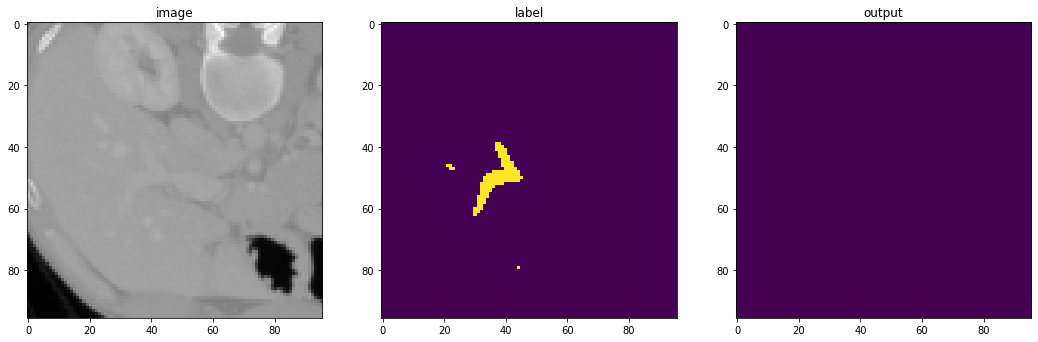

In [27]:
case_num = -1
model.load_state_dict(torch.load(os.path.join(root_dir, "best_metric_model.pth")))
# model.load_state_dict(torch.load('./best_metric_model.pth')) # PRETRAINED NETWORK
model.eval()
with torch.no_grad():
    img_name = os.path.split(val_ds[case_num]["image_meta_dict"]["filename_or_obj"])[1]
    img = val_ds[case_num]["image"]
    label = val_ds[case_num]["label"]
    val_inputs = torch.unsqueeze(img, 1).cuda()
    val_labels = torch.unsqueeze(label, 1).cuda()
    val_outputs = sliding_window_inference(
        val_inputs, size, 4, model, overlap=0.8
    )
    plt.figure("check", (18, 6))
    plt.subplot(1, 3, 1)
    plt.title("image")
    plt.imshow(val_inputs.cpu().numpy()[0, 0, :, :, slice_map[img_name]], cmap="gray")
    plt.subplot(1, 3, 2)
    plt.title("label")
    plt.imshow(val_labels.cpu().numpy()[0, 0, :, :, slice_map[img_name]])
    plt.subplot(1, 3, 3)
    plt.title("output")
    plt.imshow(
        torch.argmax(val_outputs, dim=1).detach().cpu()[0, :, :, slice_map[img_name]]
    )
    plt.show()

# Plot loss and metric

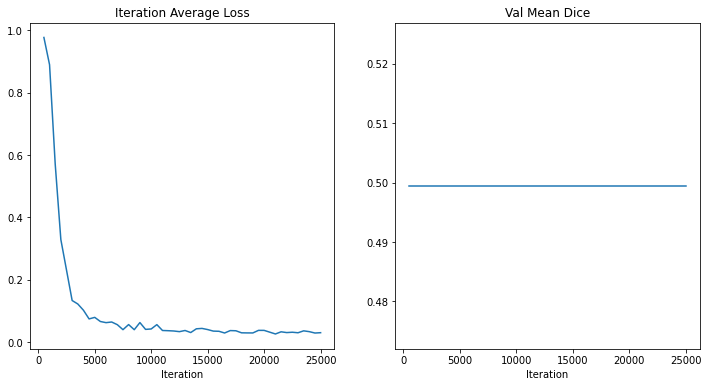

In [28]:
plt.figure("train", (12, 6))
plt.subplot(1, 2, 1)
plt.title("Iteration Average Loss")
x = [eval_num * (i + 1) for i in range(len(epoch_loss_values))]
y = epoch_loss_values
plt.xlabel("Iteration")
plt.plot(x, y)
plt.subplot(1, 2, 2)
plt.title("Val Mean Dice")
x = [eval_num * (i + 1) for i in range(len(metric_values))]
y = metric_values
plt.xlabel("Iteration")
plt.plot(x, y)
plt.show()

# Save segmentations 

In [29]:
def get_position(my_dict, key_dict, myvalue):
    
    for idx, element in enumerate(my_dict[key_dict]):
        if myvalue.split('-')[0] in element:
            return idx

In [ ]:
import skimage.transform as skTrans

In [30]:
model.load_state_dict(torch.load(os.path.join(root_dir, "best_metric_model.pth")))
# model.load_state_dict(torch.load('./best_metric_model.pth')) # PRETRAINED NETWORK
model.eval()
for case_num in range(len(dictionary['validation'])): # len(dictionary['validation']) defined in JSON !!!
    with torch.no_grad():
        img_name = os.path.split(val_ds[case_num]["image_meta_dict"]["filename_or_obj"])[1]
        img = val_ds[case_num]["image"]
        label = val_ds[case_num]["label"]
        val_inputs = torch.unsqueeze(img, 1).cuda()
        val_labels = torch.unsqueeze(label, 1).cuda()
        val_outputs = sliding_window_inference(
            val_inputs, size, 4, model, overlap=0.8
        )
        result = torch.argmax(val_outputs, dim=1).detach().cpu()[0, :, :, :].permute(2,0,1).numpy()

        pos = get_position(info_dict, 'Image name', img_name)

        unresized_result = skTrans.resize(result, (
            info_dict['Liver coordinates'][pos][1] - info_dict['Liver coordinates'][pos][0] + 1,
            info_dict['Liver coordinates'][pos][3] - info_dict['Liver coordinates'][pos][2] + 1,
            info_dict['Liver coordinates'][pos][5] - info_dict['Liver coordinates'][pos][4] + 1 
        ), order = 1, preserve_range=True)

        result = np.zeros(info_dict['Volume shape'][pos])
        result[
            info_dict['Liver coordinates'][pos][0]:info_dict['Liver coordinates'][pos][1] + 1,
            info_dict['Liver coordinates'][pos][2]:info_dict['Liver coordinates'][pos][3] + 1,
            info_dict['Liver coordinates'][pos][4]:info_dict['Liver coordinates'][pos][5] + 1 
        ] = unresized_result
        output_ima = nib.Nifti1Image(result, info_dict['Affine matrix'][pos], info_dict['Header'][pos])
        nib.save(output_ima, './data/results/' + info_dict['Image name'][pos] + '_segmented.nii.gz')